# Baseline Features

The baseline features include: `Timestamp`, `Open`, `High`, `Low`, `Close`, `Volume`.
- Working with the full index dataset (7.0M entries) can lead to excessive training times.
- We'll restrict our dataset to the most recent `100,000` data points, which are likely more relevant for future predictions.
- Note that a `training period` of only two months may not capture all relevant trends, despite containing substantial data.

## Target Variable

- We define our prediction variable `signal` using the `Close` price relative to the Bull Market Support Band (the lower of 20-week SMA and 21-week EMA).
- If closing price falls below the Bull Market Support Band, it signals a bear market, otherwise a bull market.
- The trading strategy assigns signal value = 1 (buy) in bull markets and signal value = 0 (sell) in bear markets.
- The window values for both moving averages are configurable parameters, both of which are arbitrary, and can affect the results, ideally an optimisation study needs to be carried out to find optimum values.


In [21]:
import os
import pandas as pd

PROCESSED_PATH = "data/processed/"
TEST_DATA_NAME = "test_data.csv"
VALIDATION_DATA_NAME = "validation_data.csv"

TEST_DATA_FILE = os.path.join(PROCESSED_PATH, TEST_DATA_NAME)
VALIDATION_DATA__FILE = os.path.join(PROCESSED_PATH, VALIDATION_DATA_NAME)

train_data = pd.read_csv(TEST_DATA_FILE)
valid_data = pd.read_csv(VALIDATION_DATA__FILE)
train_data.set_index("Timestamp", inplace=True)
valid_data.set_index("Timestamp", inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1396764 entries, 2022-08-16 07:30:00+00:00 to 2025-04-13 02:13:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Open    1396764 non-null  float64
 1   High    1396764 non-null  float64
 2   Low     1396764 non-null  float64
 3   Close   1396764 non-null  float64
 4   Volume  1396764 non-null  float64
dtypes: float64(5)
memory usage: 63.9+ MB


In [22]:
import numpy as np


def generate_bull_bear_signals(price_data, verbose=True):
    # Calculate 20-week SMA for minute-level data
    # 20 weeks = 20 weeks * 7 days * 24 hours * 60 minutes = 201,600 minutes
    price_data["SMA_20W"] = (
        price_data["Close"].rolling(window=201600, min_periods=1, center=False).mean()
    )

    # Calculate 21-week EMA for minute-level data
    # 21 weeks = 21 weeks * 7 days * 24 hours * 60 minutes = 211,680 minutes
    price_data["EMA_21W"] = (
        price_data["Close"].ewm(span=211680, min_periods=1, adjust=False).mean()
    )

    # Create Bull Market Support Band (the lower of the two indicators)
    price_data["Bull_Support_Band"] = price_data[["SMA_20W", "EMA_21W"]].min(axis=1)

    # Create signals: 1 (buy) when Close is above Bull Market Support Band, 0 (sell) otherwise
    price_data["signal"] = np.where(
        price_data["Close"] > price_data["Bull_Support_Band"], 1.0, 0.0
    )

    if verbose:
        display(price_data["signal"].value_counts())

    return price_data


train_data_with_signals = train_data.copy()
valid_data_with_signals = valid_data.copy()

generate_bull_bear_signals(train_data_with_signals, verbose=True)
generate_bull_bear_signals(valid_data_with_signals, verbose=False)

signal
1.0    983591
0.0    413173
Name: count, dtype: int64

,Open,High,Low,Close,Volume,SMA_20W,EMA_21W,Bull_Support_Band,signal
Timestamp,,,,,,,,,
2019-12-20 08:08:00+00:00,7120.00,7126.58,7120.00,7126.58,0.025550,7126.580000,7126.580000,7126.580000,0.0
2019-12-20 08:09:00+00:00,7120.00,7126.57,7117.37,7121.18,0.190643,7123.880000,7126.579949,7123.880000,0.0
2019-12-20 08:10:00+00:00,7118.59,7125.00,7118.59,7125.00,0.037640,7124.253333,7126.579934,7124.253333,1.0
2019-12-20 08:11:00+00:00,7118.63,7125.00,7118.63,7118.69,0.094058,7122.862500,7126.579860,7122.862500,0.0
2019-12-20 08:12:00+00:00,7117.31,7125.00,7117.28,7117.28,0.075843,7121.746000,7126.579772,7121.746000,0.0
...,...,...,...,...,...,...,...,...,...
2022-08-16 07:25:00+00:00,24026.00,24057.00,24026.00,24049.00,5.769845,29476.962661,28671.397162,28671.397162,0.0
2022-08-16 07:26:00+00:00,24035.00,24035.00,24035.00,24035.00,0.965141,29476.846585,28671.353357,28671.353357,0.0
2022-08-16 07:27:00+00:00,24050.00,24117.00,24050.00,24117.00,7.967497,29476.730930,28671.310326,28671.310326,0.0


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_target_correlation(df, target="demand", figsize=(12, 1), return_corr=False):
    # Calculate correlation matrix
    corr = df.corr()[target].drop(target, errors="ignore")

    if return_corr:
        return corr

    # Close any existing figures to prevent duplicates
    plt.close("all")

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr.to_frame().T,
        annot=True,
        cmap="coolwarm",
        center=0,
        vmin=-0.3,
        vmax=0.3,
        cbar=False,
        linewidths=1,
    )
    plt.title(f"Feature Correlation with {target}")
    plt.subplots_adjust(bottom=0.3, top=0.8)

    return plt.gcf()

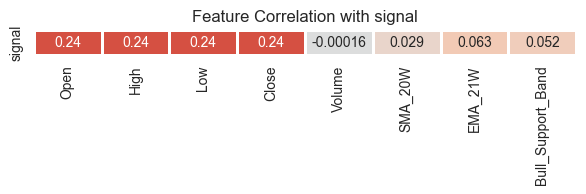

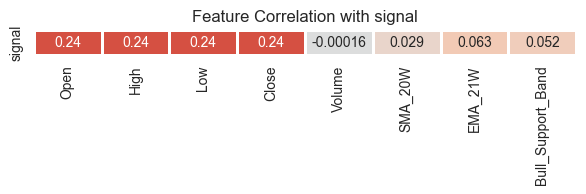

In [24]:
plot_target_correlation(train_data_with_signals, "signal", figsize=(7, 0.5))